### Import libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from pylab import figure, axes, pie, title, show

### Import Calibration Images 
Import calibration images and find object and image points

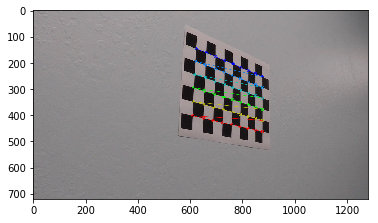

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and Save images
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = './output_images/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
# Display the last calibration images        
plt.imshow(img)


### Calculate Distortion correction coefficients

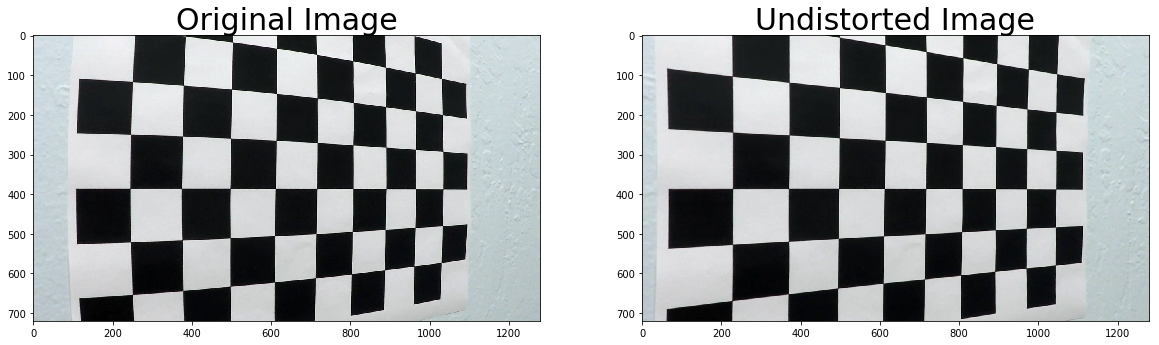

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points.
# These are global variables and will be used later in the pipeline

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/calibration5_ud.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
# save for use in writeup
plt.savefig('./output_images/chessboard_caliberated.jpg')

### Helper functions to make life easier

In [4]:
# Picked ths code snipped from the first Project
# Returns a masked image contaning only the region of interest
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Sobel with threshold
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = img
    if orient == 'x':
        grad = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        grad = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(grad)
    abs_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(abs_sobel)
    sxbinary[(abs_sobel >= thresh_min) & (abs_sobel <= thresh_max)] = 1
    return sxbinary

# Find average of numpy array given a list of numby arrays
def get_avg(arr):
    return np.mean( np.array(arr), axis=0 )

### Preprocessing and prespective transform

In [5]:
import matplotlib.image as mpimg
M = None
Minv = None
j = 0
# Performs Preprocessing and prespective transform
# Returns a Warped image and Invers prespective transform variable (Minv)
# Saves Images at each stage of processing to be used in writeup
def pre_prespective(image):
    
    global j,ret, mtx, dist, rvecs, tvecs, M, Minv
    #Correct for camera distortion
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    # Use only V channel from HSV space (Hue, Saturation, Value)
    # This is good at picking the yellow line in varying light conditions
    v_chan = cv2.cvtColor(dst,cv2.COLOR_RGB2HSV)[:,:,2]
    # Use sobel on value channel
    # This is better at picking lines at the very end of region of interest
    cv2_exp = abs_sobel_thresh(v_chan, orient='x', thresh_min=20, thresh_max=250)
    # The blue channel in rgb is used to pick the dashed white line
    b_chan=dst[:,:,2]
    # Combine them into a binary image
    
    combined = np.zeros_like(b_chan)
    combined[cv2_exp ==1] = 1
    combined[b_chan >183] = 1
    combined[v_chan >213] = 1
    # create a mask for region of interest
    imshape = image.shape
    vertices = np.array([[(0.140*imshape[1],imshape[0]*0.940),(imshape[1]*0.437,imshape[0]*0.611), (imshape[1]*0.625,imshape[0]*0.611), (imshape[1]*0.871,imshape[0]*0.940)]], dtype=np.int32)
    masked_image = region_of_interest(combined,vertices)
    # Calculate prespective transformation Matrix only once
    if M is None:
        src = np.array([[210,700],[1070,700],[690,450],[590,450]],np.float32)
        dsts = np.array([[352,720],[928,720],[928,20],[352,20]],np.float32)
        M = cv2.getPerspectiveTransform(src, dsts)
        Minv = cv2.getPerspectiveTransform(dsts, src)
    # warp the image to get birds eye view    
    warp =cv2.warpPerspective(masked_image, M, gray.shape[::-1], flags=cv2.INTER_LINEAR)
    # Save one of every hunderdth frame at various processing steps
    if j%100 == 0:
        mpimg.imsave('./output_images/'+str(j)+'.jpg',image)
        mpimg.imsave('./output_images/'+str(j)+'_undistorted.jpg',dst)
        cv2.imwrite('./output_images/'+str(j)+'_v_channel.jpg',v_chan)
        cv2.imwrite('./output_images/'+str(j)+'_x_sobel.jpg',cv2_exp*255)
        cv2.imwrite('./output_images/'+str(j)+'_b_channel.jpg',b_chan)
        cv2.imwrite('./output_images/'+str(j)+'_combined.png',combined*255)
        cv2.imwrite('./output_images/'+str(j)+'_masked.jpg',masked_image*255)
        cv2.imwrite('./output_images/'+str(j)+'_birds_eye.jpg',warp*255)
    
    return warp,Minv

### Fit a Polynomial with sliding window 

In [6]:
# This will be used for the first frame when we need to find the probable location of the lanes 

def get_fits(binary_warped):
    global j
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    if j%100 ==0:
        figure(1, figsize=(8, 6))
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('./output_images/'+str(j)+ '_window.png')
        plt.close()
    return left_fitx,right_fitx,left_fit,right_fit,ploty

### Fit a polynomial when the previous frame's left_fit & right_fit is known

In [7]:
# It's now much easier to find line pixels!
def get_fit_contineous(left_fit,right_fit,binary_warped):
    global j
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if j%100 == 0:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('./output_images/'+str(j)+ '_region.png')
        plt.close()

    return left_fitx,right_fitx,left_fit,right_fit, ploty
    

### Radius of Curvature and Distance From Center

In [8]:
# Calculate and display Curvature and Distance From Center

def radii(leftx,rightx,ploty,image):
    fontScale=2
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    ym_per_pix = 30/700 # meters per pixel in y dimension
    xm_per_pix = 3.7/576 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    average_curverad = (right_curverad+left_curverad)/2 
    # Calculate distance from center
    image_center = image.shape[1]/2
    lane_center = (leftx[-1] + rightx[-1]) /2
    center_dist = (image_center - lane_center)* xm_per_pix
    # Write Curvature and distance value to the image.
    cv2.putText(image, 'Curvature: {:.0f} m'.format( average_curverad ), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(image, 'Distance from center: {:f} m'.format(center_dist), (50, 120), font, fontScale, fontColor, 2) 
    return image

### Draw the road 
Draw the road on a blank image using the left and right lane points.
Transform back to the original prespective and overlay it on original image.

In [9]:
# Create an image to draw the lines on
def draw_road(image,binary_warped,left_fitx,right_fitx,ploty,Minv):
    global j
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    if j% 100 == 0:
        cv2.imwrite('./output_images/'+str(j)+ '_unwarped_road.jpg',color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

### Final Pipeline

In [22]:
# Global variables used to store past frame values
g_left_fit = []
g_right_fit = []
g_ploty = []
g_left_fitx = []
g_right_fitx= []

def clear_globals():
    global g_left_fit,g_right_fit,g_left_fitx,g_right_fitx,g_ploty,j
    g_left_fit = []
    g_right_fit = []
    g_ploty = []
    g_left_fitx = []
    g_right_fitx= []
    j = 0
    
# Final Pipeline
def pipeline(image):
    global g_left_fit,g_right_fit,g_left_fitx,g_right_fitx,g_ploty,j
    # Preprocess and warp image
    binary_warped,Minv = pre_prespective(image)
    # Check if the global variables have been initialized    
    if len(g_left_fit) == 0: 
        # Use sliding window if its the first frame
        left_fitx,right_fitx,left_fit,right_fit,ploty = get_fits(binary_warped)
    else:
        # Use old Left_fit and Right_fit to find the lanes in current frame
        left_fitx,right_fitx,left_fit,right_fit, ploty = get_fit_contineous(g_left_fit[-1],g_right_fit[-1],binary_warped)
    # Buffer size for averaging
    if len(g_left_fit) >10:
        #Pop if list have more elements than buffer size
        g_left_fit.pop(0)
        g_right_fit.pop(0)
        g_ploty.pop(0)
        g_left_fitx.pop(0)
        g_right_fitx.pop(0)
    # append current value to global lists    
    g_left_fit.append(left_fit)
    g_right_fit.append(right_fit)
    g_ploty.append(ploty)
    g_left_fitx.append(left_fitx)
    g_right_fitx.append(right_fitx)
    # Get average value of the buffer length
    left_fitx = get_avg(g_left_fitx)
    right_fitx = get_avg(g_right_fitx)
    left_fit = get_avg(g_left_fit)
    right_fit = get_avg(g_right_fit)
    ploty = get_avg(g_ploty)
    # Plot road and radius with the averaged values
    result = draw_road(image,binary_warped,left_fitx,right_fitx,ploty,Minv)
    result = radii(left_fitx,right_fitx,ploty,result)
    #save every 100th result for use in writeup
    if j%100 ==0:
        mpimg.imsave('./output_images/'+str(j)+'_result.jpg',result)
    # increment the count
    j+=1
    return result



### Testing Pipeline on Images

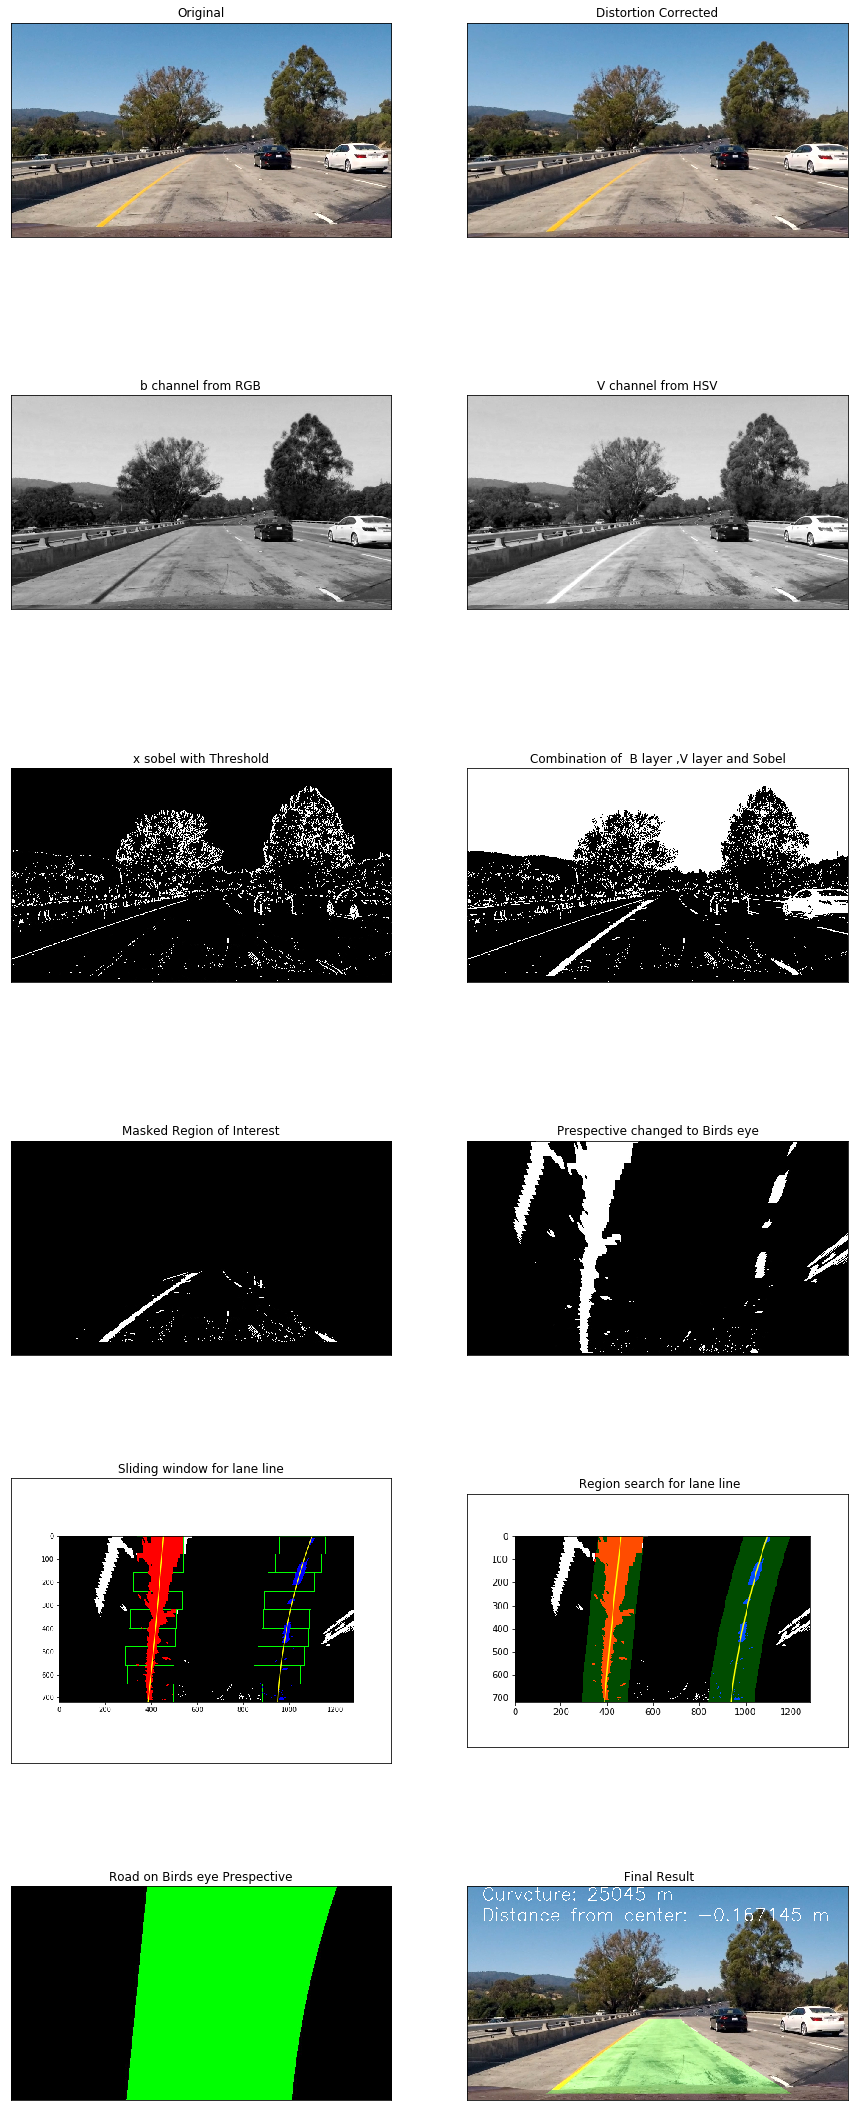

In [23]:
#test1
clear_globals()
test = mpimg.imread('./test_images/test1.jpg')
# This will triger the sliding window search 
text_result = pipeline(test)
#set j to 0 otherwise nothing will be saved
j=0
# This will trigger the region search 
text_result = pipeline(test)
stages=['.jpg','_undistorted.jpg','_b_channel.jpg','_v_channel.jpg','_x_sobel.jpg','_combined.png','_masked.jpg','_birds_eye.jpg',
        '_window.png','_region.png','_unwarped_road.jpg']
titles=['Original','Distortion Corrected','b channel from RGB',
        'V channel from HSV','x sobel with Threshold','Combination of  B layer ,V layer and Sobel',
        'Masked Region of Interest','Prespective changed to Birds eye',
        'Sliding window for lane line',' Region search for lane line','Road on Birds eye Prespective',' Final Result']

fig=plt.figure(figsize=(15,40))
columns = 2
rows = 6
for i in range(1, columns*rows):
    img = mpimg.imread('./output_images/0'+stages[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
    plt.title(titles[i-1])
    plt.xticks([])
    plt.yticks([])

# Add Result
i+=1
fig.add_subplot(rows, columns, i)
plt.imshow(text_result,cmap='gray')
plt.title(titles[i-1])
plt.xticks([])
plt.yticks([])
plt.show()


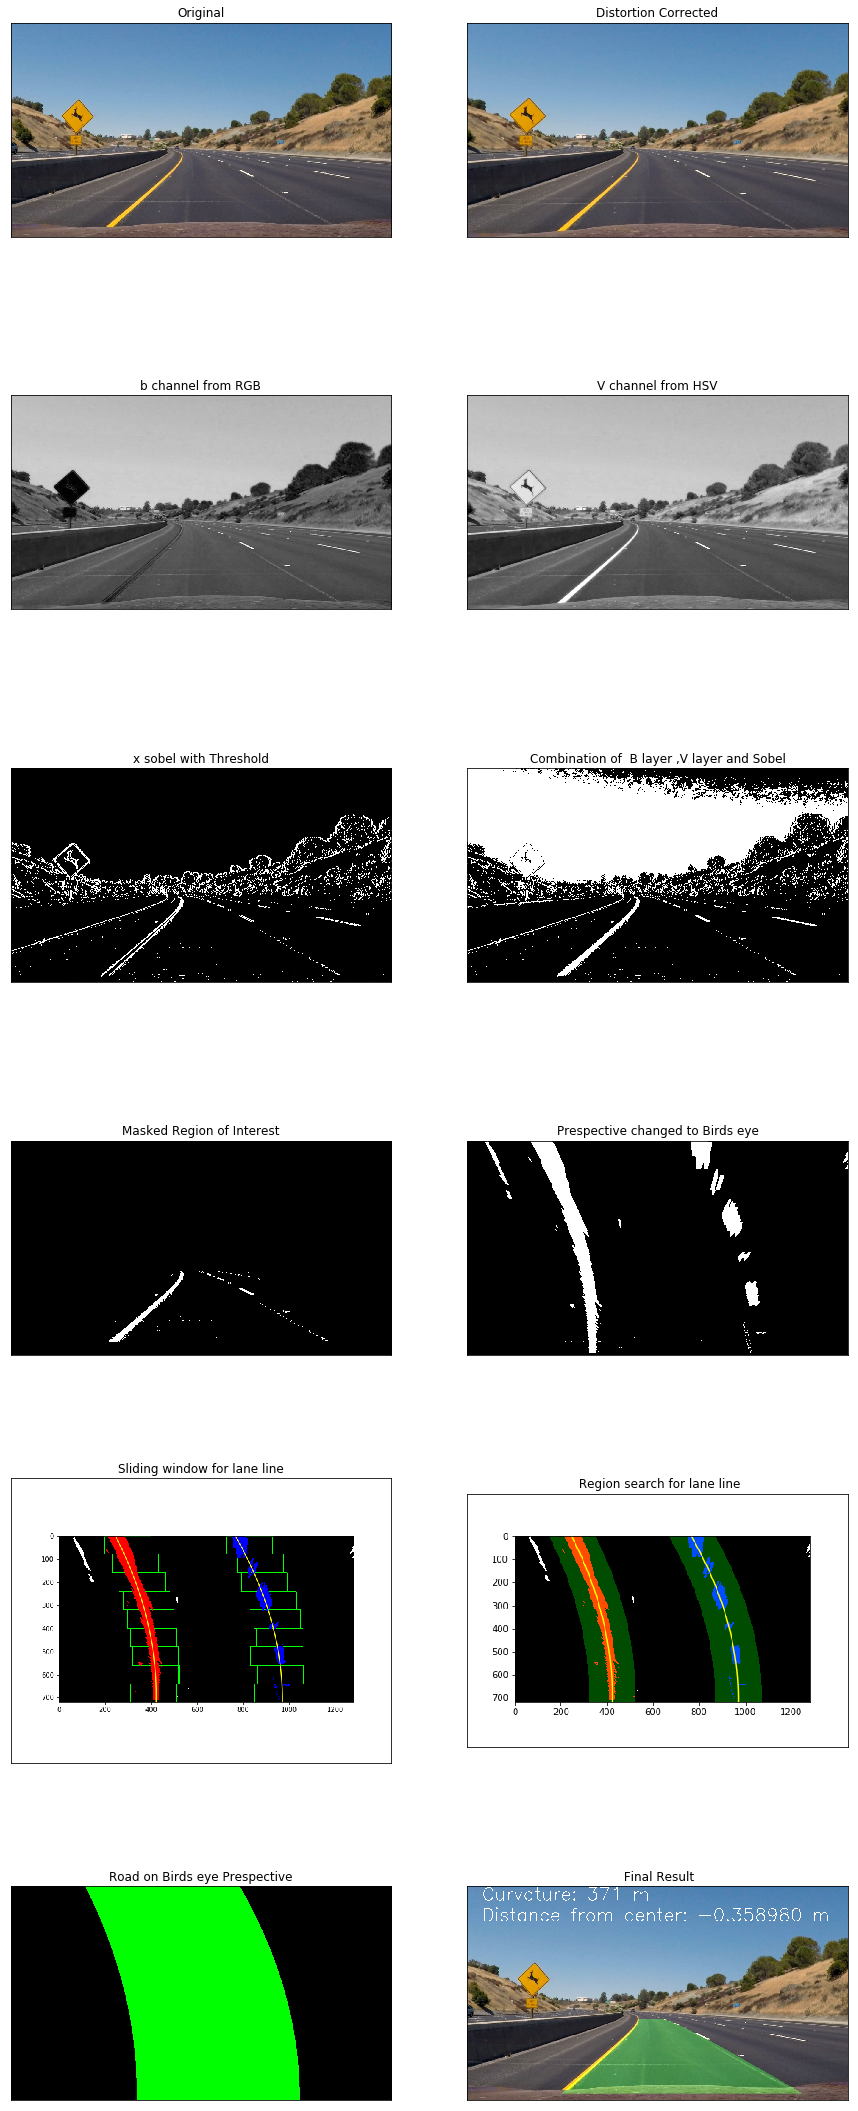

In [24]:
#test2
clear_globals()
test = mpimg.imread('./test_images/test2.jpg')

# This will triger the sliding window search 
text_result = pipeline(test)
#set j to 0 otherwise nothing will be saved
j=0
# This will trigger the region search 
text_result = pipeline(test)

fig=plt.figure(figsize=(15,40))

for i in range(1, columns*rows):
    img = mpimg.imread('./output_images/0'+stages[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
    plt.title(titles[i-1])
    plt.xticks([])
    plt.yticks([])

# Add Result
i+=1
fig.add_subplot(rows, columns, i)
plt.imshow(text_result,cmap='gray')
plt.title(titles[i-1])
plt.xticks([])
plt.yticks([])
plt.show()


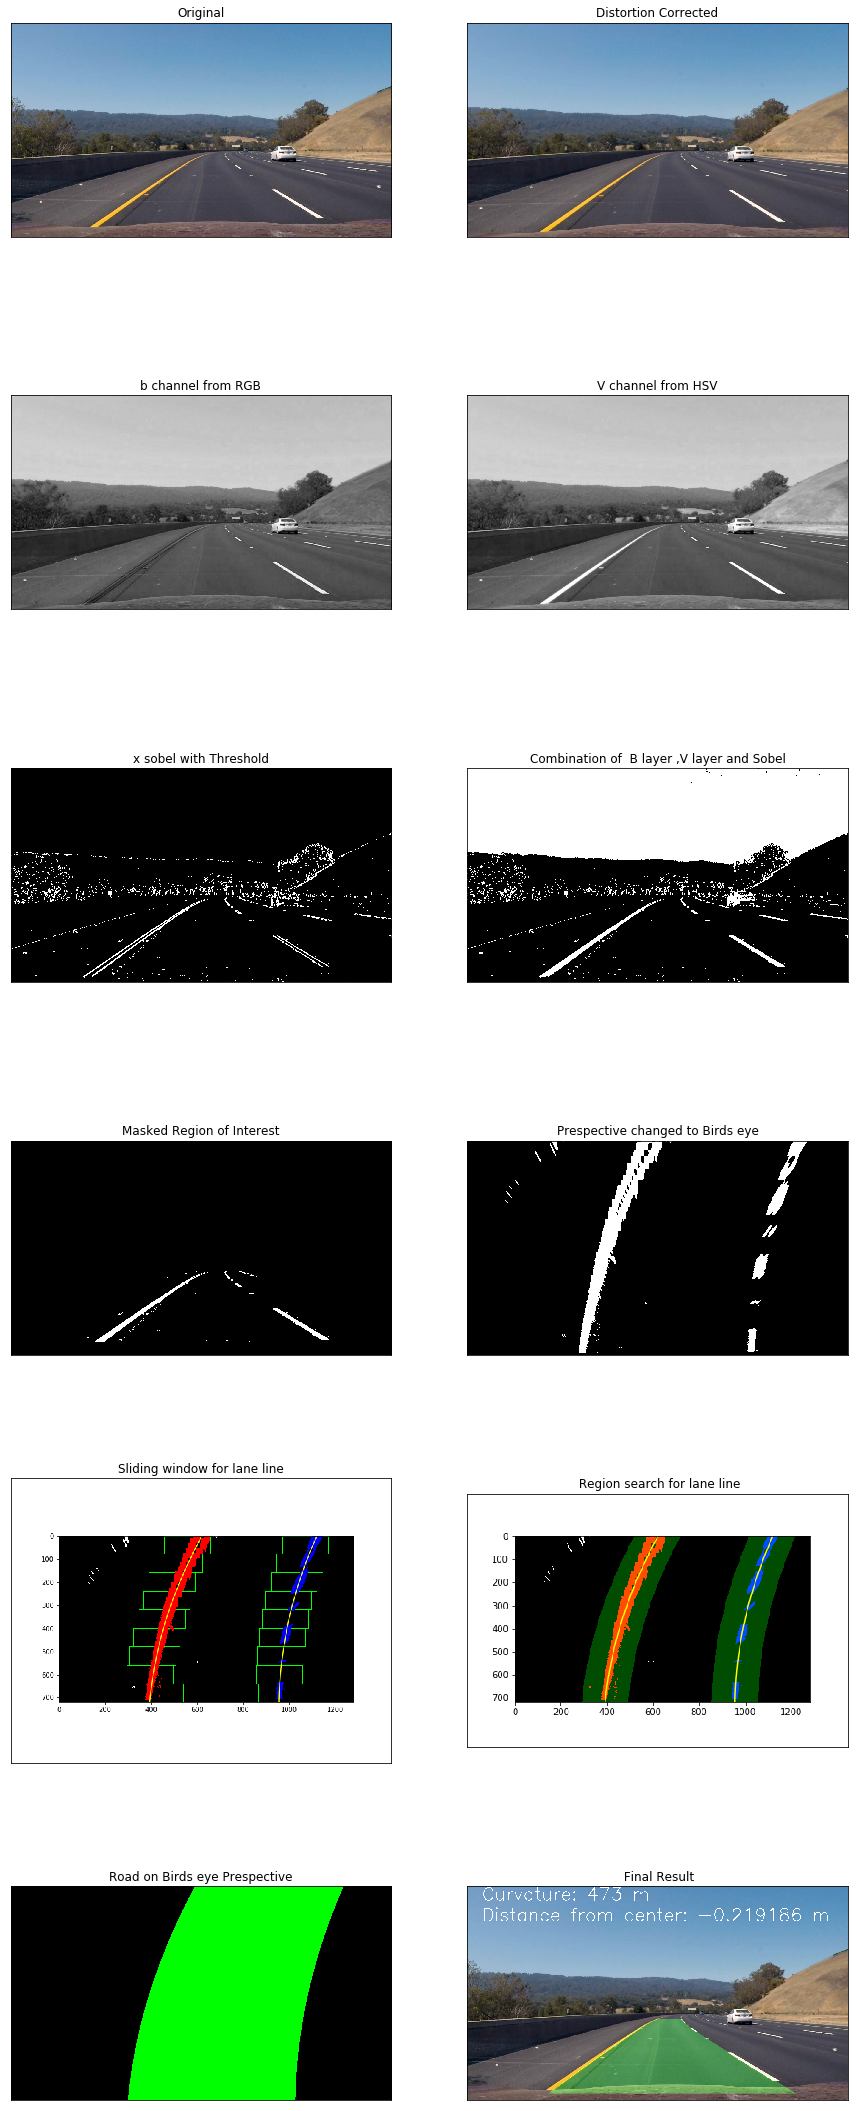

In [25]:
#test3
clear_globals()
test = mpimg.imread('./test_images/test3.jpg')
# This will triger the sliding window search 
text_result = pipeline(test)
#set j to 0 otherwise nothing will be saved
j=0
# This will trigger the region search 
text_result = pipeline(test)
fig=plt.figure(figsize=(15,40))

for i in range(1, columns*rows):
    img = mpimg.imread('./output_images/0'+stages[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
    plt.title(titles[i-1])
    plt.xticks([])
    plt.yticks([])

# Add Result
i+=1
fig.add_subplot(rows, columns, i)
plt.imshow(text_result,cmap='gray')
plt.title(titles[i-1])
plt.xticks([])
plt.yticks([])
plt.show()


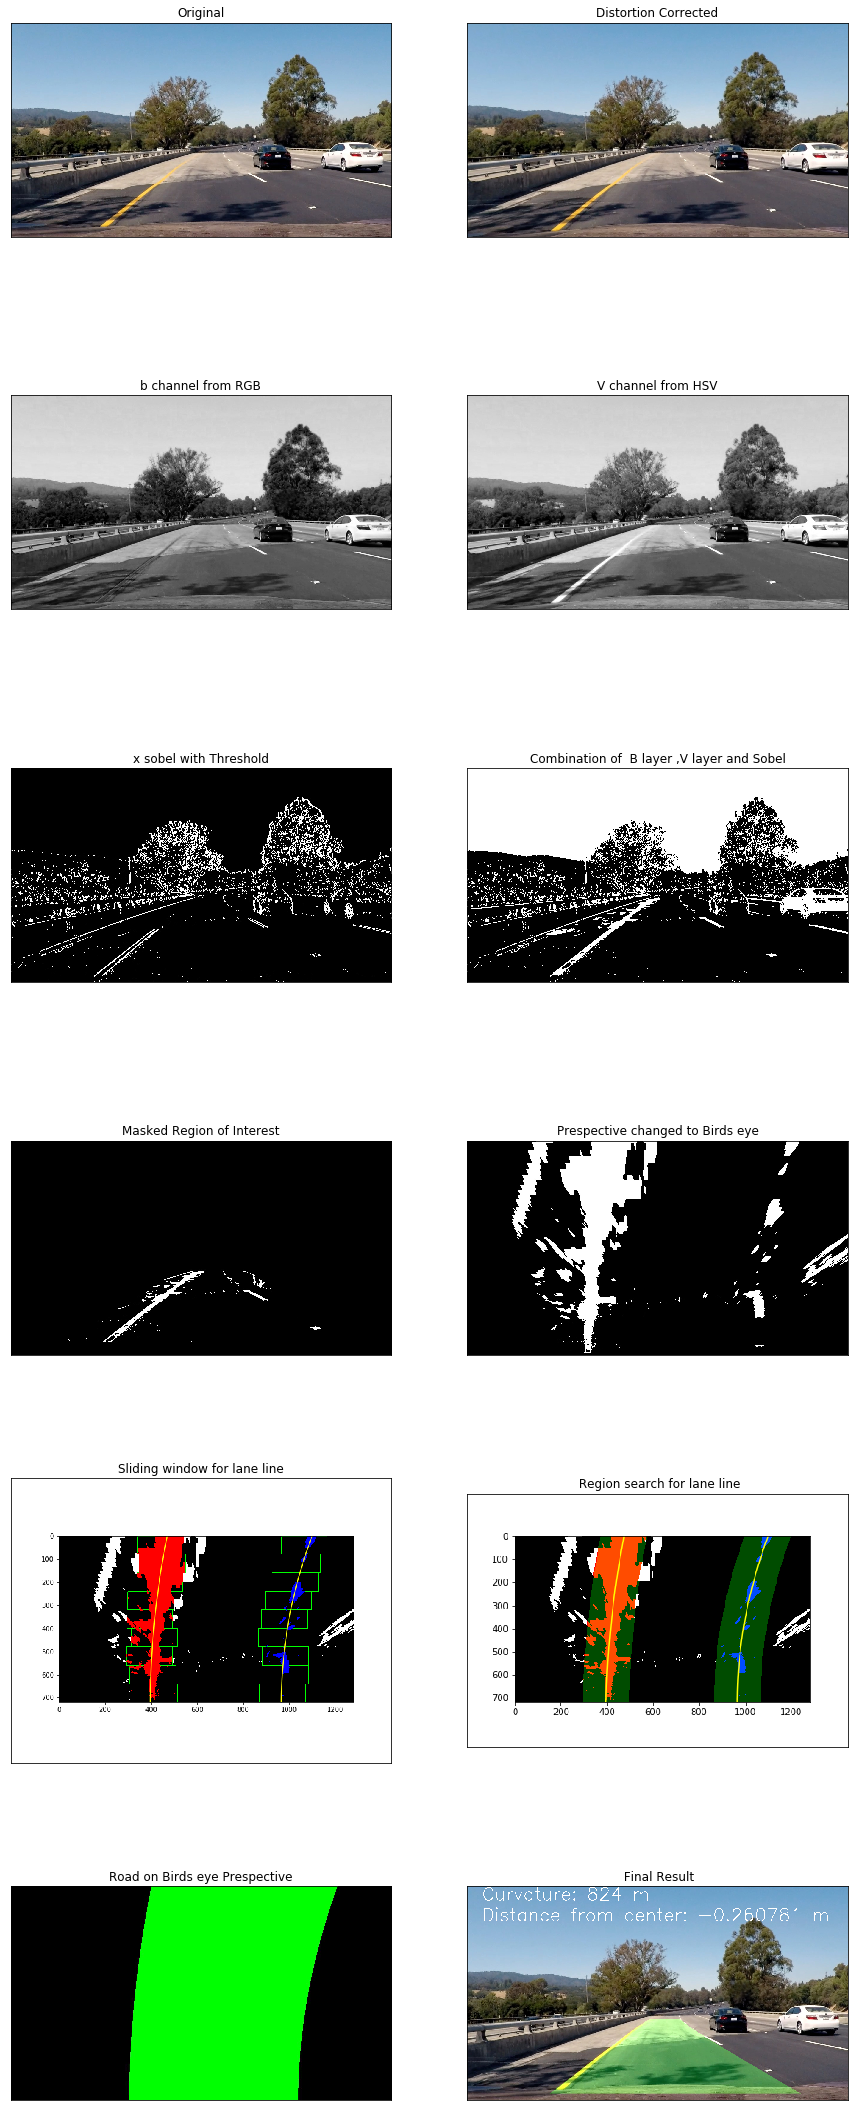

In [26]:
#test4
clear_globals()
test = mpimg.imread('./test_images/test4.jpg')
# This will triger the sliding window search 
text_result = pipeline(test)
#set j to 0 otherwise nothing will be saved
j=0
# This will trigger the region search 
text_result = pipeline(test)

fig=plt.figure(figsize=(15,40))

for i in range(1, columns*rows):
    img = mpimg.imread('./output_images/0'+stages[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
    plt.title(titles[i-1])
    plt.xticks([])
    plt.yticks([])

# Add Result
i+=1
fig.add_subplot(rows, columns, i)
plt.imshow(text_result,cmap='gray')
plt.title(titles[i-1])
plt.xticks([])
plt.yticks([])
plt.show()

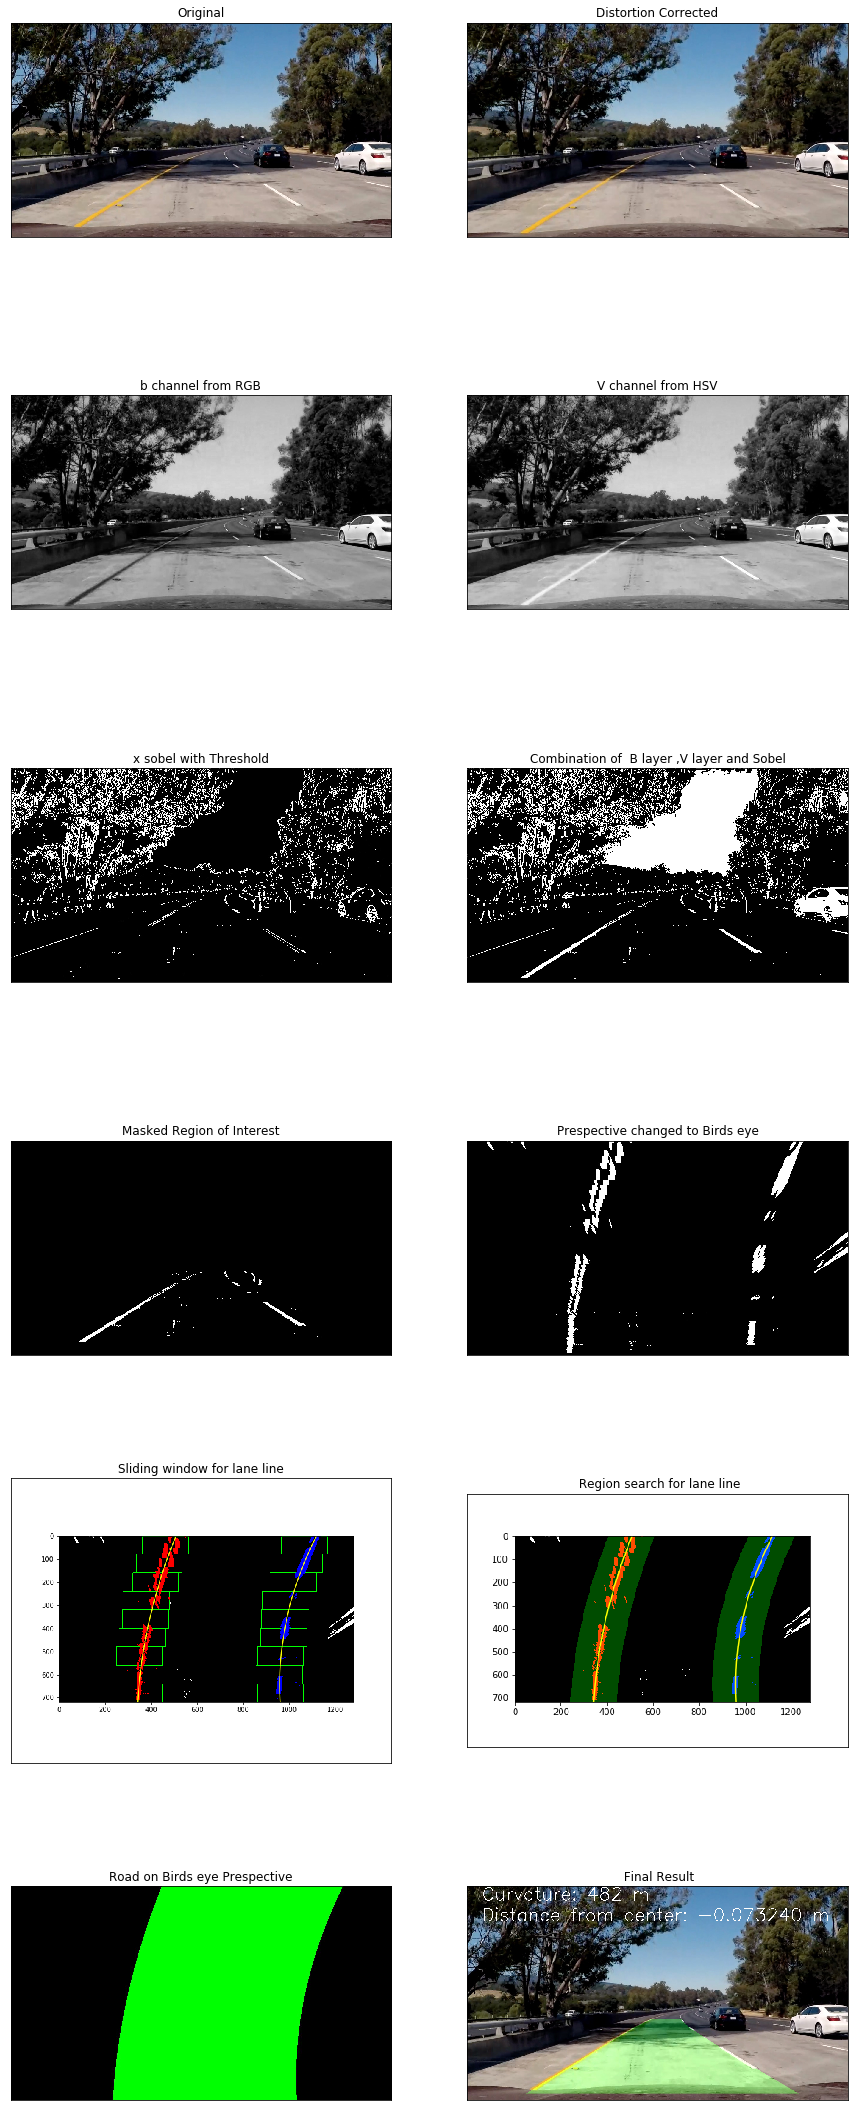

In [27]:
#test5
clear_globals()
test = mpimg.imread('./test_images/test5.jpg')
# This will triger the sliding window search 
text_result = pipeline(test)
#set j to 0 otherwise nothing will be saved
j=0
# This will trigger the region search 
text_result = pipeline(test)

fig=plt.figure(figsize=(15,40))

for i in range(1, columns*rows):
    img = mpimg.imread('./output_images/0'+stages[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
    plt.title(titles[i-1])
    plt.xticks([])
    plt.yticks([])

# Add Result
i+=1
fig.add_subplot(rows, columns, i)
plt.imshow(text_result,cmap='gray')
plt.title(titles[i-1])
plt.xticks([])
plt.yticks([])
plt.show()

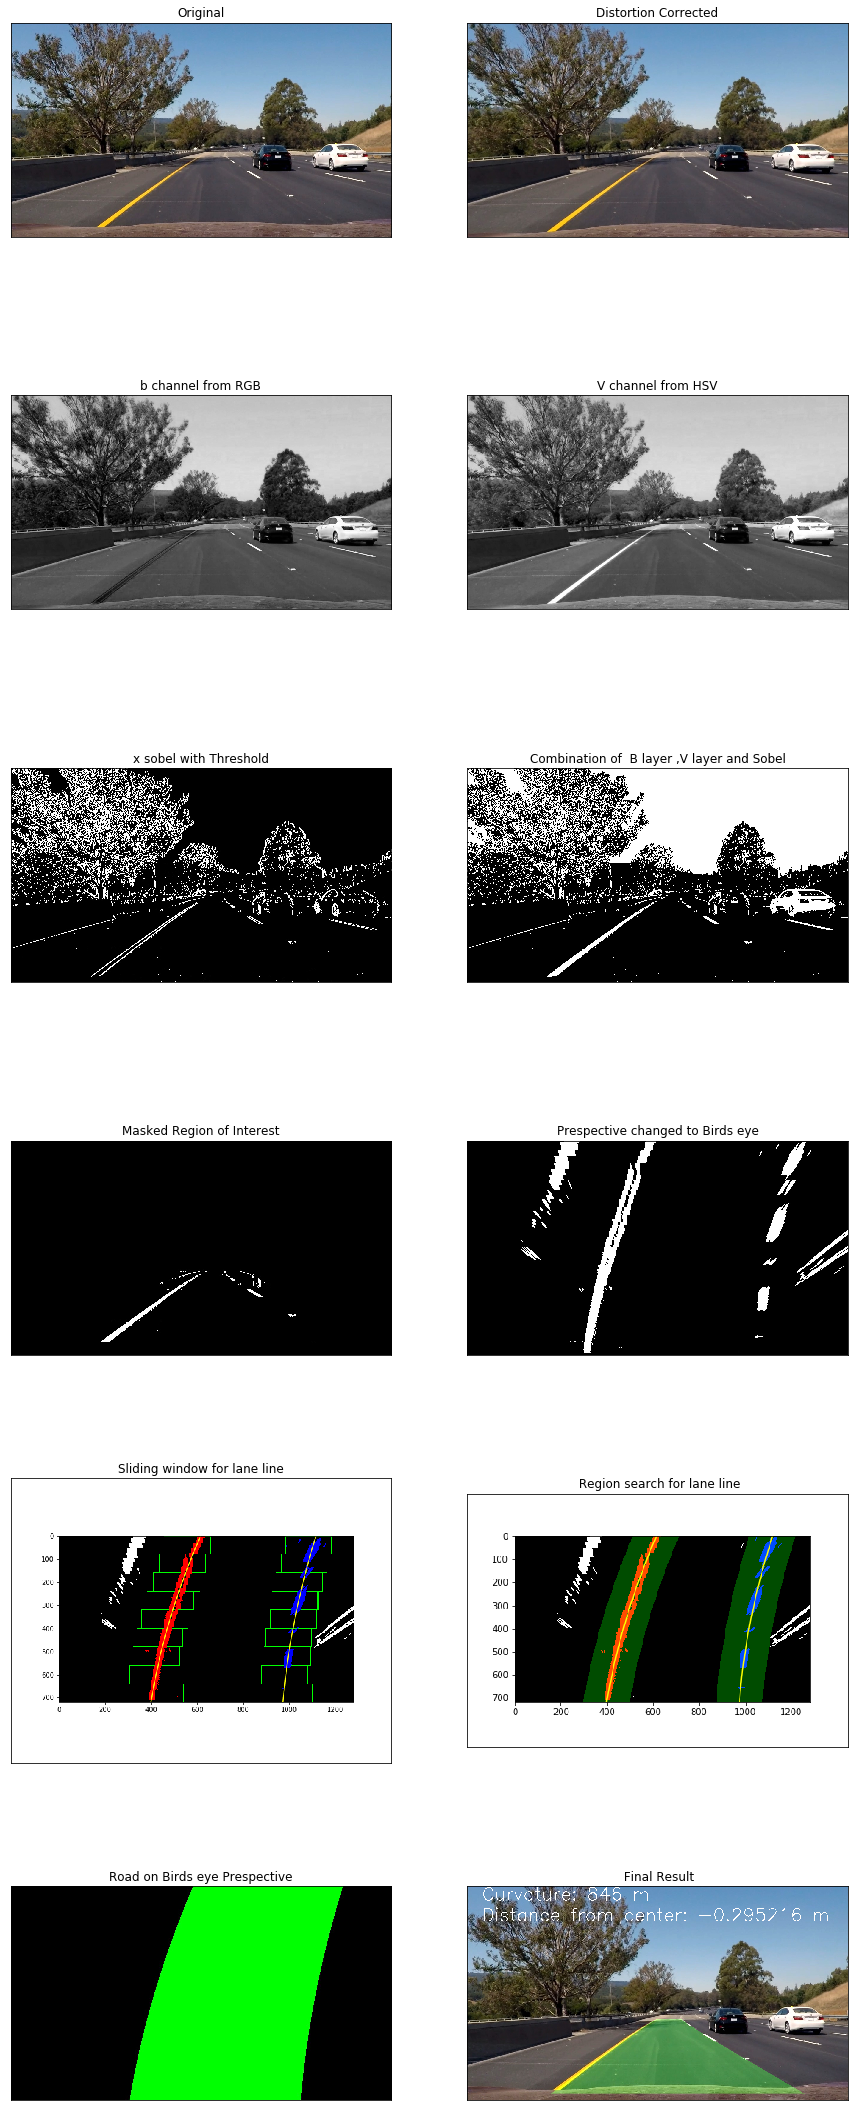

In [28]:
#test6
clear_globals()
test = mpimg.imread('./test_images/test6.jpg')
# This will triger the sliding window search 
text_result = pipeline(test)

#set j to 0 otherwise nothing will be saved
j=0

# This will trigger the region search 
text_result = pipeline(test)

fig=plt.figure(figsize=(15,40))

for i in range(1, columns*rows):
    img = mpimg.imread('./output_images/0'+stages[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
    plt.title(titles[i-1])
    plt.xticks([])
    plt.yticks([])

# Add Result
i+=1
fig.add_subplot(rows, columns, i)
plt.imshow(text_result,cmap='gray')
plt.title(titles[i-1])
plt.xticks([])
plt.yticks([])
plt.show()

In [29]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Run Pipeline for the video

In [30]:
clear_globals()
video_output = 'project_video_processed.mp4'
clip = VideoFileClip("project_video.mp4")
#clip2 = clip.subclip(22,24)
video_clip = clip.fl_image(pipeline)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:00<00:00,  3.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

Wall time: 7min 4s
